In [1]:
using HDF5; h5 = HDF5
using PyPlot; plt = PyPlot

#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples4096_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples16384_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples65536_N_seqs4.h5", "r")
fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples262144_N_seqs4.h5", "r")

τ = fid["/data/tau"][]
β = τ[end]

orders = fid["/data/orders"][]
@show orders

g_u1 = imag(fid["/data/gf/up_11"][]);
g_d1 = imag(fid["/data/gf/dn_11"][]);
g_u2 = imag(fid["/data/gf/up_22"][]);
g_d2 = imag(fid["/data/gf/dn_22"][]);

g_std_u1 = fid["/data/gf_std/up_11"][];
g_std_d1 = fid["/data/gf_std/dn_11"][];
g_std_u2 = fid["/data/gf_std/up_22"][];
g_std_d2 = fid["/data/gf_std/dn_22"][];

orders = [0, 1, 2]


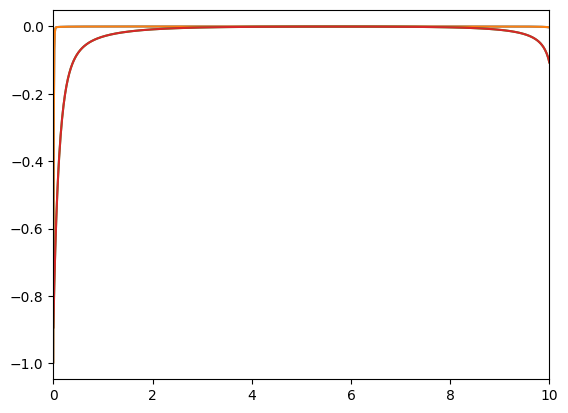

In [2]:
plt.plot(τ, g_u1, label=raw"$\uparrow,1$")
plt.plot(τ, g_d1, label=raw"$\donwarrow,1$")
plt.plot(τ, g_u2, label=raw"$\uparrow,2$")
plt.plot(τ, g_d2, label=raw"$\downarrow,2$")
plt.xlim((0, β));

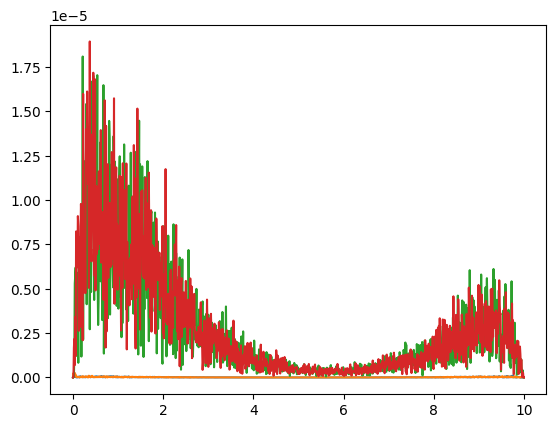

In [3]:
plt.plot(τ, real(g_std_u1), label=raw"$\uparrow,1$");
plt.plot(τ, real(g_std_d1), label=raw"$\donwarrow,1$");
plt.plot(τ, real(g_std_u2), label=raw"$\uparrow,2$");
plt.plot(τ, real(g_std_d2), label=raw"$\downarrow,2$");

# Gregory integration

In [4]:
raw"""
Compute a list of Gregory coefficients G_1, G_2, ..., G_{n_max}
using a recurrence formula

\frac{G_1}{n} - \frac{G_2}{n-1} + \frac{G_3}{n-2} - ... +
    + (-1)^{n-1}\frac{G_n}{1} = \frac{1}{n+1}.
"""
function gregory_coefficients(n_max)
    @assert n_max >= 1

    G = [0.5]
    for n in 2:n_max
        s = sum((-1) ^ (i - 1) / (n + 1 - i) * G[i] for i in 1:(n - 1))
        G_n = (-1) ^ (n - 1) * (1 / (n + 1) - s)
        push!(G, G_n)
    end

    return G
end

"Returns weights for Gregory integration"
function gregory_weights(n, order)
    stencil_size = order + 1
    @assert n > stencil_size

    # Trapezoid rule contribution
    w = ones(Float64, n)
    w[1] = w[end] = 0.5

    # Gregory boundary corrections
    if order > 0
        G = gregory_coefficients(order + 1)
        B = [sum(G[r] * (-1) ^ (r - i) * binomial(r - 1, i) for r in 2:(order + 1)) for i in 0:order]
        w[1:stencil_size] += B
        w[end-stencil_size+1:end] += B[end:-1:1]
    end
    
    return w
end

gregory_weights

# Fourier transform

In [5]:
using Interpolations
using QuadGK

function fourier(τ_list, g_τ, n_iω)
    β = τ_list[end]
    Δτ = step(τ_list)
    g_τ_itp = scale(interpolate(g_τ, BSpline(Cubic(Line(OnGrid())))), τ_list)
    g_iω = zeros(ComplexF64, 2n_iω)
    for n in -n_iω:(n_iω-1)
        ω = π * (2n + 1) / β
        g_iω[n+n_iω+1] = quadgk(τ -> g_τ_itp(τ) * exp(1im * ω * τ), 0, β, atol=1e-13)[1]
    end
    return g_iω
end

fourier (generic function with 1 method)

Test using a model function

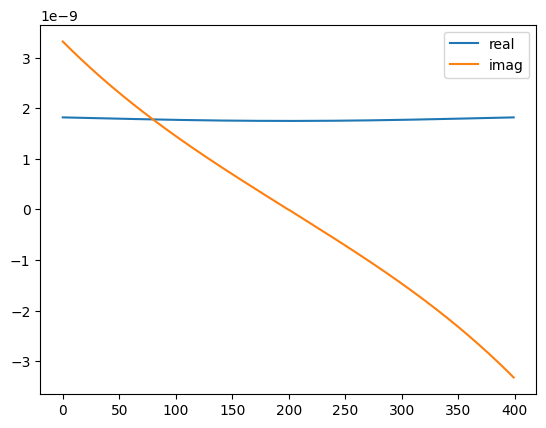

PyObject <matplotlib.legend.Legend object at 0x7f87076f8ad0>

In [6]:
n_τ = 1024
β = 10

poles = (1.0, -1.0, 0.5, -0.5)
weights = (3/32, 5/32, 11/32, 13/32)
@assert sum(weights) == 1

f(ϵ) = 1 / (1 + exp(-β * ϵ))

τ_list = range(0, β, n_τ)
g_τ_test = -[sum(w * exp(-τ * ϵ) * f(ϵ) for (ϵ, w) in zip(poles, weights)) for τ in τ_list]
@assert g_τ_test[1] + g_τ_test[end] == -1

n_iω = 200
g_iω_test = fourier(τ_list, g_τ_test, n_iω)

g_iω_ref = [sum(w / ((1im * π * (2n+1) / β) - ϵ) for (ϵ, w) in zip(poles, weights))
            for n in -n_iω:(n_iω-1)]

plt.plot(real.(g_iω_test - g_iω_ref), label="real")
plt.plot(imag.(g_iω_test - g_iω_ref), label="imag")
plt.legend()

# Analytic continuation

In [7]:
using BaryRational
using QuadGK
using LinearAlgebra: norm, diag

"Norm of a spectral function"
function dos_norm(ϵ_list, ρ)
    ρ_itp = scale(interpolate(ρ, BSpline(Cubic(Line(OnGrid())))), ϵ_list)
    return quadgk(ρ_itp, ϵ_list[1], ϵ_list[end], atol=1e-13)[1]
end

function cont(τ_list, g_τ, n_iω, ϵ_list, δ)
    println("Discontinous jump: $(-g_τ[1]-g_τ[end])")
    β = τ_list[end]
    
    iω = 1im * [π * (2n + 1) / β for n in -n_iω:(n_iω-1)]
    g_iω = fourier(τ_list, g_τ, n_iω)

    setprecision(BigFloat, 256)

    # Construct Pade approximant
    N = 2n_iω
    g = zeros(Complex{BigFloat}, N, N)
    g[1, :] = g_iω

    for p in 1:(N-1)
        # If |g| is very small, the continued fraction should be truncated.
        norm(g[p, p]) < 1e-20 && break

        for j in p:(N-1)
            x = g[p, p] / g[p, j + 1] - 1
            y = iω[j + 1] - iω[p]
            g[p + 1, j + 1] = x / y
        end
    end
    a = diag(g) # Pade coefficients

    # Evaluate the approximant at real frequencies
    ρ = zeros(Float64, length(ϵ_list))

    for (n, ϵ) in enumerate(ϵ_list)
        A1::ComplexF64 = 0
        A2 = a[1]
        B1::ComplexF64 = 1
        
        for i in 0:(N-2)
            Anew = A2 + (ϵ + 1im*δ - iω[i + 1]) * a[i + 2] * A1
            Bnew = 1.0 + (ϵ + 1im*δ - iω[i + 1]) * a[i + 2] * B1
            A1 = A2 / Bnew
            A2 = Anew / Bnew
            B1 = 1.0 / Bnew
        end
        ρ[n] = -(1 / π) * imag(A2)
    end
    
    return ρ
end

cont (generic function with 1 method)

Discontinous jump: 0.9999999999999999
DOS norm: 0.9937931839960001


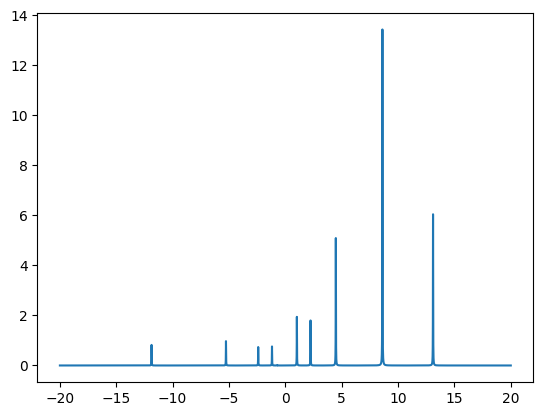

In [8]:
n_iω = 50
ϵ_list = -20:0.001:20
δ = 0.01

ρ = cont(range(0, β, length(g_u2)), g_u2, n_iω, ϵ_list, δ)

println("DOS norm: ", dos_norm(ϵ_list, ρ))
plt.plot(ϵ_list, ρ);

# TODO: Reconstruct g_τ

cond(W) = 1.92371812978486e16


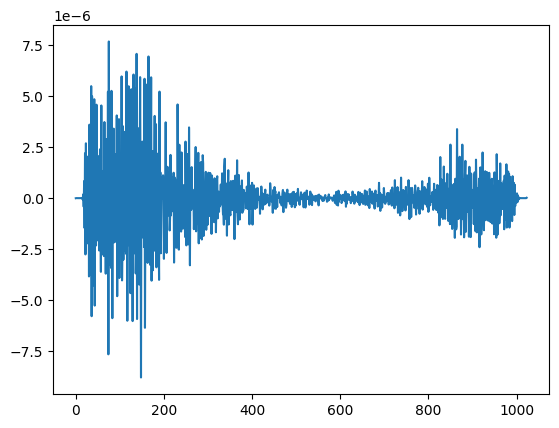

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcaaa29f950>

In [102]:
using SpecialPolynomials
using LinearAlgebra

function τ2legendre(g_τ, β, l_max)
    legendre_basis = basis.(Legendre, 0:l_max)
    W = [legendre_basis[l+1](x)
         for x in range(-1.0, 1.0, length(g_τ)),
             l in 0:l_max
        ] / β
    @show cond(W)
    return W \ g_τ
end

g_τ = g_u2

l_max = 300
Ll = basis.(Legendre, 0:l_max)
g_l = τ2legendre(g_τ, β, l_max)
#g_τ_rec = [sum(1 / β * Ll[l+1](x) * g_l[l+1] for l in 0:l_max) for x in range(-1.0, 1.0, length(g_τ))]
g_τ_rec = (1/β) * Legendre(g_l).(range(-1.0, 1.0, length(g_τ)))

#plt.plot(g_τ)
#plt.plot(g_τ_rec)
plt.plot(g_τ - g_τ_rec)

In [45]:
using Interpolations

g_τ = g_u2
g_τ_itp = scale(interpolate(g_τ, BSpline(Cubic(Line(OnGrid())))), range(0, β, length(g_τ)))

@show maximum(abs.((g_τ - g_τ_itp)))

coeffs = g_τ_itp.itp.coefs

p(δx) = 1/6 * (1-δx)^3
q(δx) = 2/3 - (δx)^2 + (δx)^3/2

@show g_τ[1]
@show g_τ_itp(0)
@show g_τ_itp.itp.coefs[0] * p(0) + g_τ_itp.itp.coefs[1] * q(0) + g_τ_itp.itp.coefs[2] * q(1) + g_τ_itp.itp.coefs[3] * p(1)

h = step(range(0, β, length(g_τ)))

@show g_τ[2]
@show g_τ_itp(h)
@show g_τ_itp.itp.coefs[1] * p(0) + g_τ_itp.itp.coefs[2] * q(0) + g_τ_itp.itp.coefs[3] * q(1) + g_τ_itp.itp.coefs[4] * p(1)

maximum(abs.(g_τ - g_τ_itp)) = 1.1102230246251565e-16
g_τ[1] = -0.8932647002355596
g_τ_itp(0) = -0.8932647002355595
g_τ_itp.itp.coefs[0] * p(0) + g_τ_itp.itp.coefs[1] * q(0) + g_τ_itp.itp.coefs[2] * q(1) + g_τ_itp.itp.coefs[3] * p(1) = -0.8932647002355595
g_τ[2] = -0.824927237814564
g_τ_itp(h) = -0.824927237814564
g_τ_itp.itp.coefs[1] * p(0) + g_τ_itp.itp.coefs[2] * q(0) + g_τ_itp.itp.coefs[3] * q(1) + g_τ_itp.itp.coefs[4] * p(1) = -0.824927237814564


-0.824927237814564